In [1]:
#%%capture
from pyicecake import pyicecake
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import PIL
from PIL import Image
import cupy as cp
from timeit import default_timer as timer

In [2]:
gc = pyicecake.GPUCache(40*1024*1024*1024) # 40GB

In [3]:
labels_dict = dict()
filenames = []
def convert_image_to_dltensor(image_folder):
    files = []
#     with open(image_folder + 'train.txt', 'r') as f:
    with open(image_folder + 'file_list.txt', 'r') as f:
        files = [line.strip() for line in f if line is not '']
    for l in files[:50000]:
        filename = l.split(' ')[0]
        if filename.endswith(""):
            filenames.append(filename)
            npbuff = np.asarray(PIL.Image.open(image_folder+filename), dtype=np.uint8)
            gc.put_numpy_array(filename, npbuff)

In [4]:
time1 = timer()
# convert_image_to_dltensor('/mnt/optane-ssd/lipeng/imagenet/')
convert_image_to_dltensor('/home/lwangay/dali-data/images/')
time2 = timer()
print(time2 - time1)
for f in filenames[:10]:
    print(f)
print(len(filenames))

0.07637716829776764
dog/dog_1.jpg
dog/dog_2.jpg
dog/dog_3.jpg
dog/dog_4.jpg
dog/dog_5.jpg
dog/dog_6.jpg
dog/dog_7.jpg
dog/dog_8.jpg
dog/dog_9.jpg
dog/dog_10.jpg
21


In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
def show_all_imgs(imgs):
    _, axs = plt.subplots(5, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

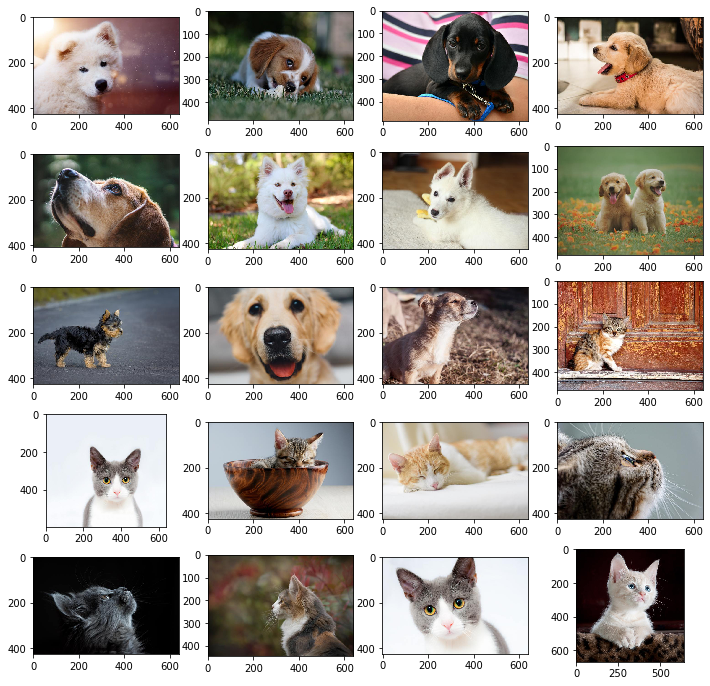

In [6]:
imgs = []
for f in filenames[:20]:
    npbuff = gc.get_numpy_array(f)
    img = PIL.Image.fromarray(npbuff)
    imgs.append(img)
show_all_imgs(imgs)
    



In [7]:
# import shutil,os
# for f in filenames:
#     os.makedirs(os.path.dirname('/mnt/optane-ssd/lipeng/imagenet/5000/'+f), exist_ok=True)
#     shutil.copy('/mnt/optane-ssd/lipeng/imagenet/'+f, '/mnt/optane-ssd/lipeng/imagenet/5000/'+f) 
    

In [8]:
batch_size=100

In [9]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.files = filenames

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            batch.append(filenames[self.i])
            self.i = (self.i + 1) % self.n
        return batch

    next = __next__

In [10]:
eii = ExternalInputIterator(batch_size)
iterator = iter(eii)

In [11]:
def read_from_icecake():
    ret = iterator.next()
    dltensors = []
    for f in ret:
#         print(f)
        dltensors.append(gc.get_dltensor(f, 0))
    return dltensors

class DLTensorPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(DLTensorPipeline, self).__init__(batch_size,num_threads,device_id,exec_async=False,
                                             exec_pipelined=False,seed=12)
        self.read_from_icecake = ops.DLTensorPythonFunction(function=read_from_icecake, device='gpu', 
                                              synchronize_stream=True, batch_processing=True)
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
        self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
    def define_graph(self):
        res = self.read_from_icecake()
        res = self.crop(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return res



In [12]:
pipe = DLTensorPipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

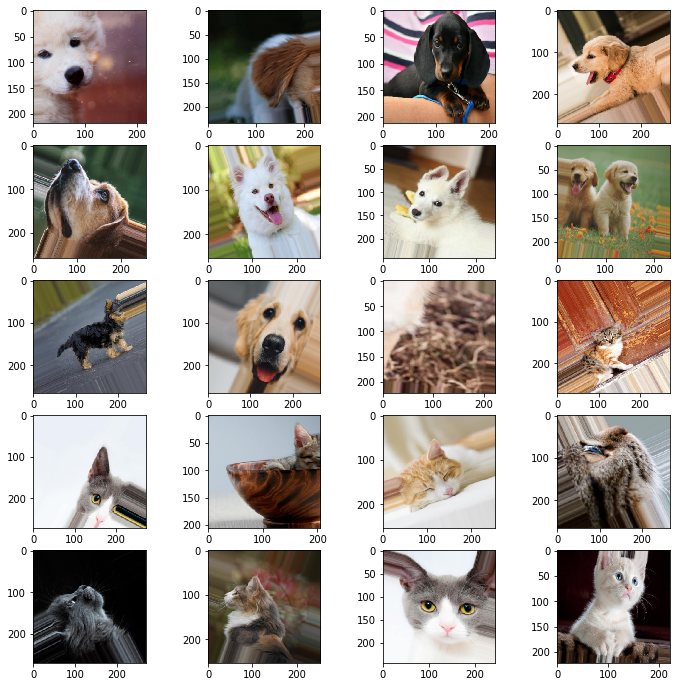

In [13]:
imgs = []
for i in range(0, 5):
    pipe_out = pipe.run()
    im, = pipe_out
    img=im.as_cpu()
    for i in img:
        imgs.append(i)
    
show_all_imgs(imgs)
    

In [14]:
from timeit import default_timer as timer

In [35]:
def speedtest(pipeclass, batch, n_threads, eii = None):
    pipe = None
    if eii is not None:
        pipe = pipeclass(batch, n_threads, 0, eii)
    else:
        pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 500
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("time: {}".format(t))
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [45]:
class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = "/home/lwangay/dali-data/images/", random_shuffle = True)

#         self.input = ops.FileReader(file_root = "/mnt/optane-ssd/lipeng/imagenet/5000/train", random_shuffle = True)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.crop = ops.RandomResizedCrop(device='cpu', size=[200,200])
        self.rotate = ops.Rotate(device='cpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
    def define_graph(self):
        jpegs, labels = self.input()
        res = self.decode(jpegs)
        res = self.crop(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return (res, labels)

In [55]:
class MixedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(MixedPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
#         self.input = ops.FileReader(file_root = "/mnt/optane-ssd/lipeng/imagenet/5000/train", random_shuffle = True)
        self.input = ops.FileReader(file_root = "/home/lwangay/dali-data/images/", random_shuffle = True)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)
        self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
    def define_graph(self):
        jpegs, labels = self.input()
        res = self.decode(jpegs)
        res = self.crop(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return (res, labels)

In [47]:
gc.config_shuffle(True)
import nvidia.dali.plugin_manager as plugin_manager
import os
plugin_manager.load_library(os.path.dirname(pyicecake.__file__)+"/libdali_icecake.so")
class CustomOperatorPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(CustomOperatorPipeline, self).__init__(batch_size,num_threads,device_id,seed=12)
        self.read_from_icecake = ops.DaliIcecake(GPUCacheObjAddr=gc.get_self_pointer(), device='gpu')
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
        self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
    def define_graph(self):
        res = self.read_from_icecake()
        res = self.crop(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return res
pipe = CustomOperatorPipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [48]:
nthread = 4

In [49]:
speedtest(SimplePipeline, batch_size, nthread)

time: 84.09555093385279
Speed: 594.5617746095581 imgs/s


In [56]:
speedtest(MixedPipeline, batch_size, nthread)

time: 7.015228454954922
Speed: 7127.351635239267 imgs/s


In [51]:
#speedtest(DLTensorPipeline, batch_size, nthread)

In [52]:
speedtest(CustomOperatorPipeline, batch_size, nthread)

time: 3.0083596194162965
Speed: 16620.353390364067 imgs/s
